# How to estimate a star's mass and radius using asteroseismology

## Learning Goals

In this tutorial you will learn:

- What the periodogram of a star with solar-like oscillations looks like.
- How the oscillations can be characterized by two key metrics ($\nu_{\rm max}$ and $\Delta\nu$). 
- How these metrics can be used to estimate a star's mass, radius, and surface gravity.

## Introduction

Stars of all shapes and sizes oscillate. In many cases, these oscillations are created by standing waves formed inside of the star, which disturb the stellar surface. The study of these types of internal oscillations is called *asteroseismology*.

This tutorial focuses on a very common type of oscillating star: *solar-like oscillators*. This type includes main sequence stars like the Sun as well as many red giant stars. Stars of this type experience convection in the outer layers of their atmospheres. As material moves up and down in these layers, the turbulent motion forms damped standing waves throughout the stellar interior. Because these waves probe the full stellar interior, we can estimate fundamental properties of a star by studying how these waves disturb the surface of the star. Properties which can be inferred in this way include mass, radius, surface gravity, and even age for the most advanced studies.

In this tutorial we will explain two key metrics asteroseismologists use to characterize the oscillations of a Sun-like star: the average frequency spacing $\Delta\nu$, and the frequency of maximum oscillation amplitude $\nu_{\rm max}$. We will also demonstrate how these metrics can be used to estimate the mass, radius, and surface gravity of a star.

## Imports

This tutorial requires **[Lightkurve](https://docs.lightkurve.org)** (for its features to handle *Kepler* data) and **[NumPy](https://numpy.org/)** (to help plot some additional details on figures).  We will use **[Matplotlib](https://matplotlib.org/)** for plotting.

In [1]:
import lightkurve as lk
import numpy as np
%matplotlib inline

---

## 1. Plotting the Frequency Spectrum of a Sun-Like Star

The frequency spectrum (also known as periodogram) of a solar-like oscillator like the Sun shows a rich spectrum of modes of oscillation, equally spaced in frequency, colloquially referred to as a "comb."

We will investigate this spectrum using the Sun-like star KIC 10963065 as an example. This star is also colloquially known as "Rudy" (cf. [Lund et al. 2016](https://arxiv.org/pdf/1612.00436.pdf)). In order to get a good resolution in the frequency domain, we start by downloading and combining four quarters of Short Cadence *Kepler* data as follows:

In [2]:
search_result = lk.search_lightcurve('KIC 10963065',
                                     cadence='short', 
                                     author='Kepler',
                                     quarter=(2,5,6,7))
lc = search_result.download_all().stitch()

In one of the companion tutorials, we already identified the location of the modes of oscillation, so we'll zoom in on that region right away when creating the periodogram. We also set the [`normalization='psd'`](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.LombScarglePeriodogram.html#lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve) keyword argument, to match the common conventions in asteroseismology of solar-like oscillators.

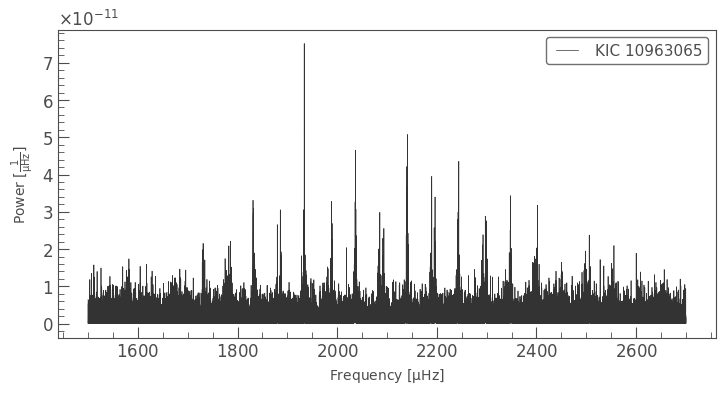

In [3]:
pg = lc.to_periodogram(normalization='psd',
                       minimum_frequency=1500,
                       maximum_frequency=2700)
ax = pg.plot();

In this spectrum we can see that the modes of oscillation rise up from the noise, reach a peak, and then decrease in power. This region, where the modes are visible, is commonly referred to as the *mode envelope*. The peak of this envelope is what we call the *frequency of maximum oscillation amplitude*, or $\nu_{\rm max}$ (colloquially called "numax").

An approximation of the shape of the envelope (roughly a Gaussian function) is shown as the dashed line in the figure below. We also overlay a smoothed version of the power spectrum, and annotate the location of the oscillation modes with arrows. Making this figure is an optional step, but it helps to visualize the oscillation features:

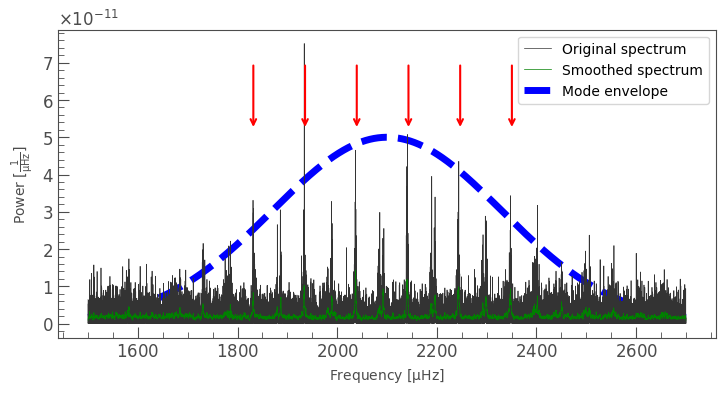

In [4]:
# Plot a smoothed version of the power spectrum on top in green
ax = pg.plot(label='Original spectrum')
pg.smooth(filter_width=1).plot(ax=ax,
                               color='green',
                               label='Smoothed spectrum')

# Highlight the "mode envelope" using a Gaussian curve
f = pg.frequency.value
ax.plot(f, 5e-11*np.exp(-(f-2100)**2/(2*230**2)),
        lw=5, ls='--', zorder=0,
        color='blue', label='Mode envelope');

# Annotate the modes using red arrows
for i in range(6):
  ax.annotate('',
              xy=(1831.66+i*103.8, 5.2e-11),
              xytext=(1831.66+i*103.8, 7e-11), 
              arrowprops=dict(arrowstyle='->',
              color='red',
              linewidth=1.5))
ax.legend();

A distinctive feature in the spectrum is the equal spacing of the modes of oscillation. The spacing between two consecutive overtones of the same radial order (for example, radial oscillations, dipole oscillations, etc.) is what we call the *average large frequency spacing*, or $\Delta\nu$ (colloquially called "deltanu"). In the figure above, the arrows point to dipole modes of oscillation (hemispheres expanding and contracting alternately), and are all evenly spaced.

Both of these metrics, $\nu_{\rm max}$ and $\Delta\nu$, are very useful because they are related to the mass, radius, and temperature of the star. The next step in our tutorial is to estimate the values of these metrics, using Lightkurve's tools.

## 2. Estimating the Frequency of Maximum Amplitude $\nu_{\rm max}$

The frequency of maximum amplitude can be estimated in a number of ways. An obvious estimate would be to take the frequency that corresponds to the maximum amplitude in the power spectrum. This would not be a robust estimate however, because the maximum peak is very sensitive to noise and sampling effects. 

Instead, one of the most commonly used methods to estimate $\nu_{\rm max}$ is the 2D autocorrelation function (ACF) method. Literature publications using this method include, for example, [Huber et al. (2009)](https://arxiv.org/abs/0910.2764) and [Viani et al. (2019)](https://arxiv.org/abs/1905.08333). A version of this method is provided by the Lightkurve package.

Before diving into Lightkurve's tools, we will need to prepare our [Periodogram](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.Periodogram.html?highlight=periodogram#lightkurve.periodogram.Periodogram) object. We do this by first removing background noise using the [flatten()](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.Periodogram.flatten.html?highlight=flatten#lightkurve.periodogram.Periodogram.flatten) method:

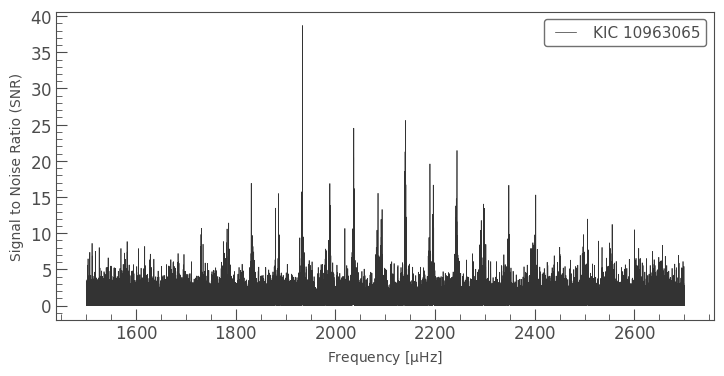

In [5]:
snr = pg.flatten()
ax = snr.plot();

Next, we need to convert the periodogram to a [Seismology](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.html?highlight=seismology) object, which hosts Lightkurve's asteroseismology tools:

In [6]:
seismology = snr.to_seismology()

Lightkurve's estimation method uses the autocorrelation function (ACF). Autocorrelation values are the result of calculating the correlation of the data with itself as it is gradually shifted over itself. One way to imagine how the ACF method works is by holding your hands up side by side and slowly shifting them past one another. Where your fingers overlap, the ACF will be high, and vice versa.


The [Seismology](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.html?highlight=seismology) object provides both `estimate` and `diagnose` methods. The former estimates the value, and the latter shows us how it was calculated. First, let's call [estimate_numax()](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.estimate_numax.html?highlight=estimate_numax):

In [7]:
seismology.estimate_numax()

numax: 2145.00 uHz (method: ACF2D)

Here, the [estimate_numax()](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.estimate_numax.html?highlight=estimate_numax)) function has measured a value for $\nu_{\rm max}$ from our `SNRPeriodogram`, and has stored it as a property of the [Seismology](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.html?highlight=seismology) object. We can access the value as follows:

In [8]:
seismology.numax.value

2145.0

Before moving on, let's have a look at exactly how $\nu_{\rm max}$ was measured, using the [`diagnose_numax()`](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.diagnose_numax.html?highlight=diagnose_numax) function.

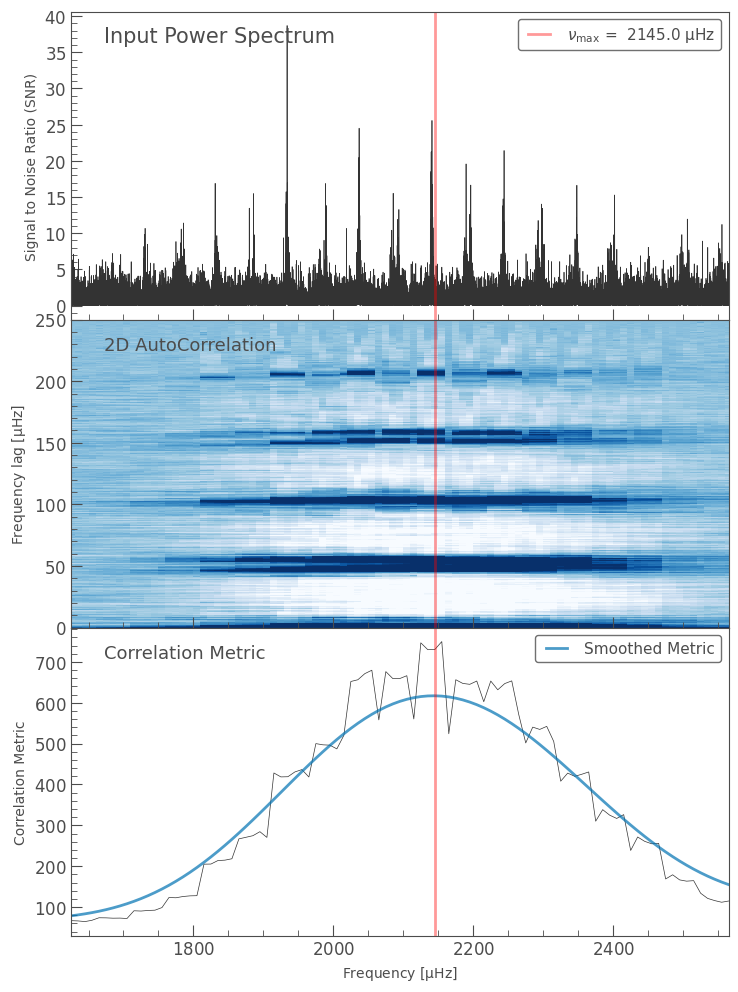

In [9]:
seismology.diagnose_numax();

The figure above shows three plots, so let's break them down, one by one:

1. The top panel shows the original periodogram. 
2. The middle panel shows an image representing the ACF values calculated for different parts of the power spectrum. In this case, each segment used to calculate the ACF is $250\, \mu\rm{Hz}$ wide, which you can see on the y-axis. The x-axis is the central frequency of each segment, and the z-axis (the color) shows the strength of the autocorrelation function. As we get closer to the frequency of maximum oscillation, the colors get darker, and so the ACF is increasing.
3. The bottom panel shows the same autocorrelation values as the middle panel, but collapsed (that is, summed) along the y-axis. The integrated value of the ACF is strongest closest to the frequency of maximum oscillation. The blue line over the top is a smoothed version of the collapsed ACF. Lightkurve estimates  $\nu_{\rm max}$ by computing the maximum of the smoothed blue line. The resulting estimate is marked across all three panels using the vertical red line.

Now that we have estimated a value for $\nu_{\rm{max}}$, calculating $\Delta\nu$ becomes faster. We can observe the features of $\Delta\nu$ in the middle panel above: there are repeating peaks in the ACF, corresponding to repeating features overlapping, just like the fingers on your hand. The spacing between these repeating peaks will be used to estimate $\Delta\nu$.

## 3. Estimating the Frequency Spacing $\Delta\nu$

In order to estimate $\Delta\nu$ efficiently, we can use the fact that we only need to investigate the ACF in the region surrounding $\nu_{\rm max}$. In this region, peaks in the ACF will show up corresponding to the repeating comb structure overlapping with itself.

Having an estimate of $\nu_{\rm max}$ also makes measuring $\Delta\nu$ possible in a second way. Using well-established empirical relations which have been published in the literature, we can infer the Full Width Half Maximum (FWHM) of the mode envelope based on the value of $\nu_{\rm max}$. This helps us further narrow down the region in which to calculate the ACF.  Lightkurve uses the relationships published by [Mosser et al. 2010](https://arxiv.org/abs/1004.0449) and [Lund et al. 2017](https://arxiv.org/abs/1612.00436), which are:

$$
\textrm{FWHM} \approx 0.25 \times \nu_{\rm max}\, \text{for main sequence stars, and}$$

$$\textrm{FWHM} \approx 0.66 \times \nu_{\rm max}^{0.88}\, \text{for red giants.}$$

We can also use $\nu_{\rm max}$ to make a rough estimate of $\Delta\nu$ to guide our search for the true $\Delta\nu$. This is roughly

$$\Delta\nu \approx 0.294 \times \nu_{\rm max}^{0772}\, ,$$

which we assume to be the same for all solar-like oscillators ([Stello et al. 2009](https://arxiv.org/abs/0909.5193)).

To understand how this works in practice, let's first [estimate_deltanu()](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.estimate_deltanu.html?highlight=estimate_deltanu), and then [diagnose_deltanu()](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.diagnose_deltanu.html?highlight=diagnose_deltanu).

In [10]:
seismology.estimate_deltanu()

deltanu: 103.11 uHz (method: ACF2D)

Now let's see how this $\Delta\nu$ value was obtained.

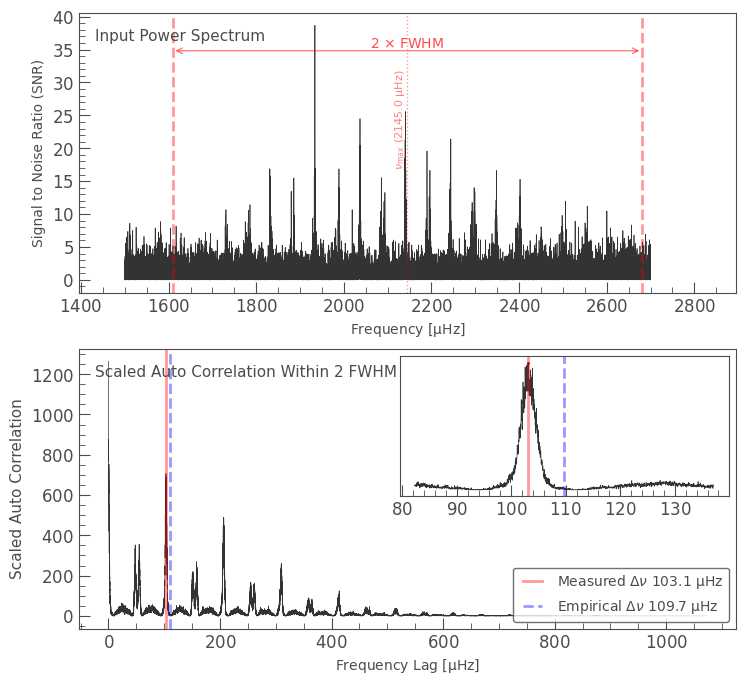

In [11]:
seismology.diagnose_deltanu();

In the top panel we see the region in the frequency spectrum for which the ACF is evaluated, which is one FWHM on either side of $\nu_{\rm max}$. This region encompasses the strongest modes of oscillation.

In the bottom panel we can see the ACF, that is, the result of calculating the correlation of the data with itself as it is shifted over itself. Where modes of oscillation overlap with one another, there will be a spike in the ACF. Because the modes are regularly spaced, these spikes will also be regularly spaced, and will reflect the spacing between modes of oscillation.

The inset on the upper right hand corner shows a region around the *empirically* estimated $\Delta\nu$, which is based on the literature equations shown above. Using the [Scipy](https://www.scipy.org/) find_peaks() function, Lightkurve finds the tip of the ACF peak nearest to this estimate, and reports this as the *measured* $\Delta\nu$.

## 4. Estimating Stellar Mass, Radius, and Surface Gravity

Having obtained estimates for $\Delta\nu$ and $\nu_\rm{max}$, we can now estimate the star's mass ($M$), radius ($R$), and surface gravity ($g$) given an estimate for the star's effective temperature ($T_\rm{eff}$). Asteroseismologists have established three *scaling relations* between these properties. These scaling relations read as follows:

$$\frac{M}{M_\odot} \simeq \left(\frac{\nu_\rm{max}}{\nu_\rm{max,\odot}}\right)^3 \left(\frac{\Delta\nu}{\Delta\nu_{\odot}}\right)^{-4}\left(\frac{T_{\rm eff}}{T_{\rm eff,\odot}}\right)^{3/2}\, ,$$

$$
\frac{R}{R_\odot} \simeq \left(\frac{\nu_\rm{max}}{\nu_\rm{max,\odot}}\right) \left(\frac{\Delta\nu}{\Delta\nu_{\odot}}\right)^{-2}\left(\frac{T_{\rm eff}}{T_{\rm eff,\odot}}\right)^{1/2}\, \text{and}
$$

$$
\frac{g}{g_\odot} \simeq \left(\frac{\nu_\rm{max}}{\nu_\rm{max,\odot}}\right) \left(\frac{T_{\rm eff}}{T_{\rm eff,\odot}}\right)^{1/2}\,
$$

where the $\odot$ symbol represents the Sun. In Lightkurve, the solar values used are $\nu_{\rm max, \odot} = 3090\, \mu\rm{Hz}$, $\Delta\nu_\odot = 135.1\, \mu{\rm Hz}$ ([Huber et al. 2010](https://arxiv.org/abs/1010.4566)) and $T_{\rm eff, \odot} = 5777.2\, \rm{K}$ ([Prša et al. 2016](https://arxiv.org/abs/1605.09788)).

These scaling relations are built into Lightkurve. We can call them as follows:

In [12]:
seismology.estimate_mass()

mass: 1.08 solMass (method: Uncorrected Scaling Relations)

In [13]:
seismology.estimate_radius()

radius: 1.23 solRad (method: Uncorrected Scaling Relations)

In [14]:
seismology.estimate_logg()

logg: 4.29 dex (method: Uncorrected Scaling Relations)

For the last one, surface gravity ($g$) is expressed in log space (that is, $\log g$), which is the convention in stellar physics. If we look at our  [Seismology](https://docs.lightkurve.org/reference/api/lightkurve.seismology.Seismology.html?highlight=seismology) object now, we'll see that it has stored all of these variables in one place.

In [15]:
seismology

Seismology(ID: KIC 10963065) - computed values:
 * numax: 2145.00 uHz (method: ACF2D)
 * deltanu: 103.11 uHz (method: ACF2D)
 * mass: 1.08 solMass (method: Uncorrected Scaling Relations)
 * radius: 1.23 solRad (method: Uncorrected Scaling Relations)
 * logg: 4.29 dex (method: Uncorrected Scaling Relations)

## 5. Closing Remarks

In this tutorial, we have seen how Lightkurve's tools can be used to estimate the mass, radius, and surface gravity of a solar-like oscillator. We did this by first estimating the seismic observables $\nu_{\rm max}$ and $\Delta\nu$. 
It is important to remember, however, that these are *estimates*, and that the method built into Lightkurve is an adaptation of established 2D ACF methods designed to provide first look estimates of stellar properties. Lightkurve's implementation has not been tested thoroughly in the literature yet, and it does not provide uncertainties yet.

If you're interested in learning more about asteroseismology, we recommend the following review papers:

- [Chaplin & Miglio (2013)](https://arxiv.org/pdf/1303.1957.pdf) provides a review on asteroseismology of solar-like oscillators with *Kepler*, including an explanation of the seismic scaling relations.
- [Aerts (2019)](https://arxiv.org/pdf/1912.12300.pdf) provides a comprehensive review that covers asteroseismology of a wide range of oscillating stars, including solar-like oscillators.

Or even better, get in contact and collaborate with an asteroseismologist!

## About this Notebook

**Authors**: Oliver Hall (oliver.hall@esa.int), Geert Barentsen

**Updated On**: 2020-09-29

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [16]:
lk.show_citation_instructions()

<img style="float: left;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
